In [2]:
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

2025-05-05 09:56:43.450504: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-05 09:56:43.476367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746421003.513214   14494 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746421003.527639   14494 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-05 09:56:43.573563: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
TARGET_SR = 16000         
N_MFCC = 40                
SEGMENT_LENGTH = 3        
TIME_STEPS = 100           
HOP_LENGTH_RATIO = 0.5     

data = pd.read_csv("processed_deepfake_urdu.csv")
labels = np.where(data["class"] == "Spoofed", 1, 0)  # Binary labels: 1 for "Spoofed", 0 for "Bonafide"

def extract_mfcc(file_path):

    audio, sr = librosa.load(file_path, sr=TARGET_SR)
    n_fft = min(len(audio), 2048) 
    hop_length = int(n_fft * HOP_LENGTH_RATIO)  
    mfcc = librosa.feature.mfcc(
        y=audio, sr=sr, n_mfcc=N_MFCC, n_fft=n_fft, hop_length=hop_length
    )

    if mfcc.shape[1] < TIME_STEPS:
        padding = np.zeros((N_MFCC, TIME_STEPS - mfcc.shape[1]))
        mfcc = np.hstack((mfcc, padding))
    else:
        mfcc = mfcc[:, :TIME_STEPS]

    return mfcc.T  

mfccs = []
for idx, file in enumerate(data["file_path"]):
    try:
        mfcc = extract_mfcc(file)
        mfccs.append(mfcc)
        print(f"Successfully processed file: {file}")
    except Exception as e:
        print(f"Error processing file {file}: {e}")

mfccs = np.array(mfccs)
print(f"MFCC Shape: {mfccs.shape}")  # (num_samples, TIME_STEPS, N_MFCC)
print(f"Labels Shape: {labels.shape}")  # Ensure labels match samples

Successfully processed file: processed_data/Bonafide_Speaker_01_317_seg0.wav
Successfully processed file: processed_data/Bonafide_Speaker_01_317_seg1.wav
Successfully processed file: processed_data/Bonafide_Speaker_01_317_seg2.wav
Successfully processed file: processed_data/Bonafide_Speaker_01_707_seg0.wav
Successfully processed file: processed_data/Bonafide_Speaker_01_707_seg1.wav
Successfully processed file: processed_data/Bonafide_Speaker_01_260_seg0.wav
Successfully processed file: processed_data/Bonafide_Speaker_01_260_seg1.wav
Successfully processed file: processed_data/Bonafide_Speaker_01_671_seg0.wav
Successfully processed file: processed_data/Bonafide_Speaker_01_671_seg1.wav
Successfully processed file: processed_data/Bonafide_Speaker_01_671_seg2.wav
Successfully processed file: processed_data/Bonafide_Speaker_01_504_seg0.wav
Successfully processed file: processed_data/Bonafide_Speaker_01_504_seg1.wav
Successfully processed file: processed_data/Bonafide_Speaker_01_273_seg0.wav

/home/qasim/Desktop/genai/.venv/lib/python3.12/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Successfully processed file: processed_data/Bonafide_Speaker_02_261_seg0.wav
Successfully processed file: processed_data/Bonafide_Speaker_02_261_seg1.wav
Successfully processed file: processed_data/Bonafide_Speaker_02_505_seg0.wav
Successfully processed file: processed_data/Bonafide_Speaker_02_505_seg1.wav
Successfully processed file: processed_data/Bonafide_Speaker_02_501_seg0.wav
Successfully processed file: processed_data/Bonafide_Speaker_02_501_seg1.wav
Successfully processed file: processed_data/Bonafide_Speaker_02_659_seg0.wav
Successfully processed file: processed_data/Bonafide_Speaker_02_659_seg1.wav
Successfully processed file: processed_data/Bonafide_Speaker_02_303_seg0.wav
Successfully processed file: processed_data/Bonafide_Speaker_02_303_seg1.wav
Successfully processed file: processed_data/Bonafide_Speaker_02_670_seg0.wav
Successfully processed file: processed_data/Bonafide_Speaker_02_670_seg1.wav
Successfully processed file: processed_data/Bonafide_Speaker_02_699_seg0.wav

In [ ]:
def plot_mfccs(mfccs, labels, num_to_plot=4, sample_rate=16000, time_steps=100, hop_length_ratio=0.5, n_fft=2048):

    # Ensure we don't plot more MFCCs than available
    num_to_plot = min(num_to_plot, mfccs.shape[0])
    
    # Calculate hop length and time axis
    hop_length = int(n_fft * hop_length_ratio)  # 1024
    time_axis = np.arange(time_steps) * hop_length / sample_rate  # Time in seconds
    
    # Set up the plot with subplots (2x2 grid for 4 MFCCs)
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.ravel()  # Flatten axes for easy iteration
    
    for i in range(num_to_plot):
        mfcc = mfccs[i]  # Shape: (time_steps, n_mfcc)
        
        # Plot MFCC as a heatmap
        im = axes[i].imshow(
            mfcc.T,  # Transpose to have time on x-axis, coefficients on y-axis
            aspect='auto',
            origin='lower',
            cmap='viridis',
            interpolation='nearest'
        )
        
        # Set labels and title
        class_label = 'Spoofed' if labels[i] == 1 else 'Bonafide'
        axes[i].set_title(f'MFCC {i+1} ({class_label})')
        axes[i].set_xlabel('Time (s)')
        axes[i].set_ylabel('MFCC Coefficients')
        
        # Set x-axis ticks in seconds
        axes[i].set_xticks(np.linspace(0, time_steps-1, 5))
        axes[i].set_xticklabels(np.round(np.linspace(0, time_axis[-1], 5), 2))
        
        # Set y-axis ticks for MFCC coefficients
        axes[i].set_yticks(np.arange(0, mfcc.shape[1], 10))
        axes[i].set_yticklabels(np.arange(1, mfcc.shape[1]+1, 10))
        
        # Add colorbar for amplitude
        plt.colorbar(im, ax=axes[i], label='Amplitude')
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Display the plot
    plt.show()

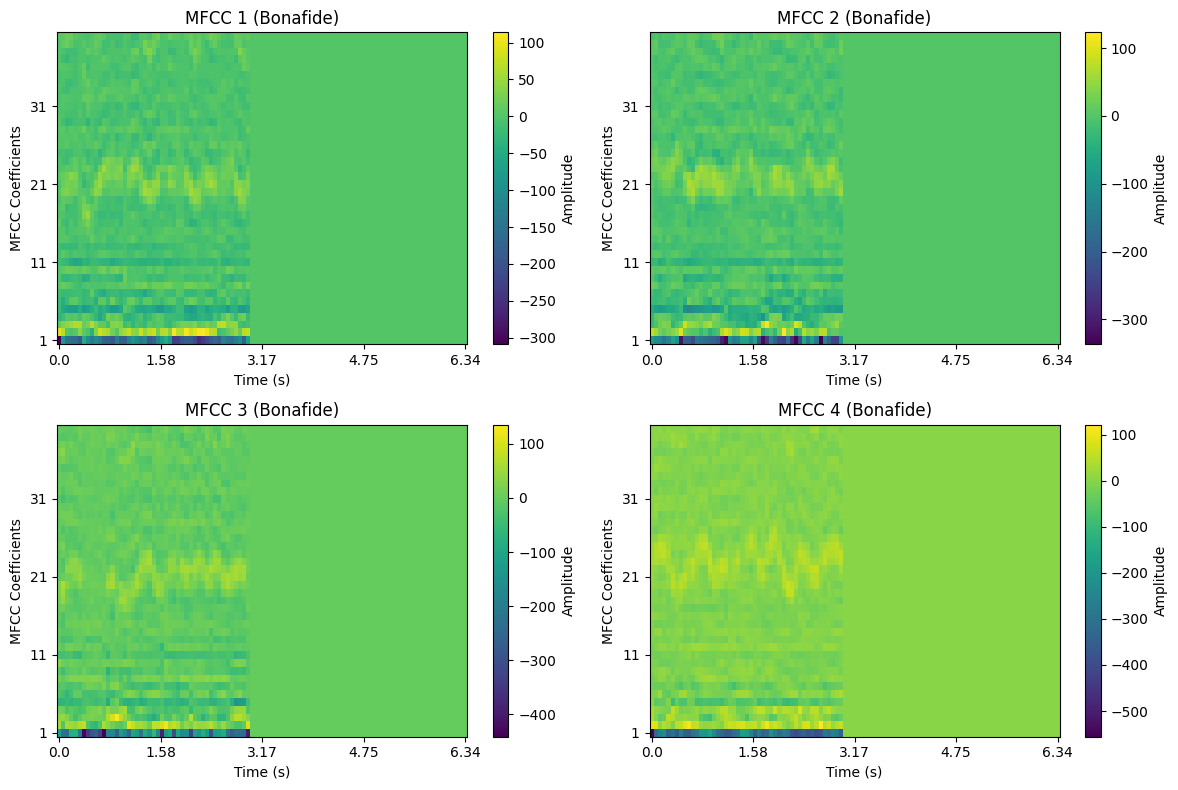

In [8]:
plot_mfccs(mfccs, labels)

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(
    mfccs, labels, test_size=0.3, random_state=42, stratify=labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [7]:
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (14508, 100, 40), (14508,)
Validation data shape: (3109, 100, 40), (3109,)
Test data shape: (3109, 100, 40), (3109,)


In [8]:
model = models.Sequential([
    layers.Input(shape=(TIME_STEPS, N_MFCC)),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2025-01-26 19:22:09.666201: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 64)        │        26,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,385 (157.75 KB)

 Trainable params: 40,385 (157.75 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=64,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])


Epoch 1/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 42s 152ms/step - accuracy: 0.7416 - loss: 0.5189 - val_accuracy: 0.9180 - val_loss: 0.2319
Epoch 2/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 39s 172ms/step - accuracy: 0.9357 - loss: 0.1693 - val_accuracy: 0.9575 - val_loss: 0.1122
Epoch 3/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 43s 188ms/step - accuracy: 0.9668 - loss: 0.1059 - val_accuracy: 0.9682 - val_loss: 0.0952
Epoch 4/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 75s 159ms/step - accuracy: 0.9715 - loss: 0.0893 - val_accuracy: 0.9675 - val_loss: 0.0813
Epoch 5/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 35s 154ms/step - accuracy: 0.9732 - loss: 0.0711 - val_accuracy: 0.9620 - val_loss: 0.0820
Epoch 6/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 36s 158ms/step - accuracy: 0.9800 - loss: 0.0567 - val_accuracy: 0.9781 - val_loss: 0.0598
Epoch 7/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 37s 163ms/step - accuracy: 0.9812 - loss: 0.0569 - val_accuracy: 0.9633 - val_loss: 0.0839
Epoch 8/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 40s 175ms/step - accuracy: 0.9766 - loss: 0

In [10]:
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred, target_names=["Bonafide", "Spoofed"]))

98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step
              precision    recall  f1-score   support

    Bonafide       0.94      0.99      0.96      1515
     Spoofed       0.99      0.94      0.96      1594

    accuracy                           0.96      3109
   macro avg       0.97      0.97      0.96      3109
weighted avg       0.97      0.96      0.96      3109



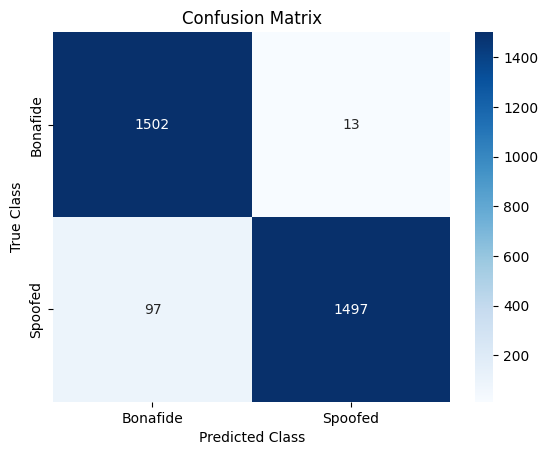

In [21]:
# Define class labels
class_labels = ["Bonafide", "Spoofed"]

# plt.figure(figsize=(6, 6))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()


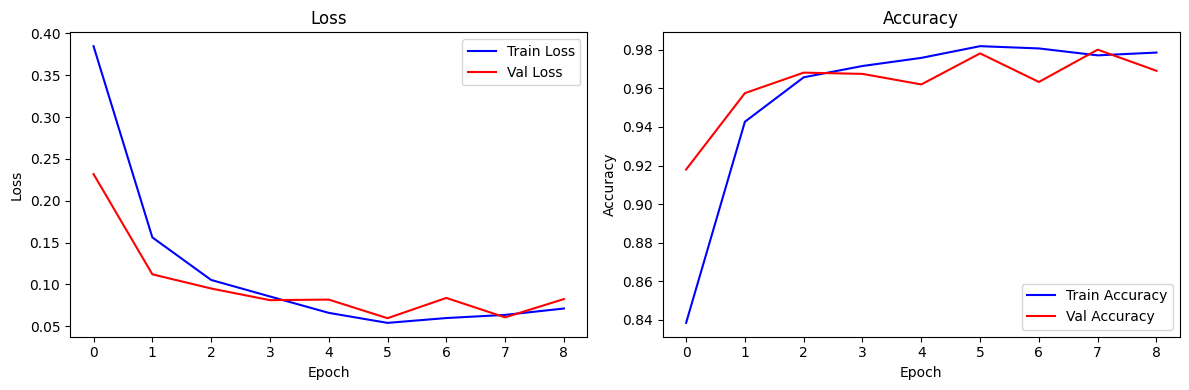

In [23]:
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss", color="blue")
plt.plot(history.history["val_loss"], label="Val Loss",color="red")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy",color="blue")
plt.plot(history.history["val_accuracy"], label="Val Accuracy",color="red")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
model.save("lstm_mfcc.h5")